# Sentiment Analysis of IMDB Movie Reviews
Dalam proyek ini, dilakukan analisis sentimen terhadap ulasan berbahasa Indonesia menggunakan dua pendekatan representasi teks populer: Bag of Words (BoW) dan TF-IDF (Term Frequency - Inverse Document Frequency). Kedua pendekatan ini kemudian diuji menggunakan algoritma Logistic Regression untuk mengukur efektivitasnya dalam mengklasifikasikan sentimen sebagai positif atau negatif.

Untuk mengevaluasi performa model, digunakan beberapa metrik penting seperti akurasi, precision, recall, dan f1-score. Tak hanya itu, disertakan juga confusion matrix guna memberikan gambaran yang lebih detail tentang bagaimana model melakukan klasifikasi pada masing-masing kelas.

# Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings('ignore')


# Persiapan Data

In [2]:
imdb_data=pd.read_csv('https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0
5,"For my humanities quarter project for school, ...",1
6,Arguebly Al Pacino's best role. He plays Tony ...,1
7,Being a big fan of Stanley Kubrick's Clockwork...,1
8,I reached the end of this and I was almost sho...,1
9,There is no doubt that Halloween is by far one...,1


## Menghitung banyak sentimen antar review

In [3]:
imdb_data['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

We can see that the dataset is balanced.

# Preprocessing Data

## Split data training dan data testing

In [4]:
# train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]

# test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]

print("Dimensi data training: ", train_reviews.shape,train_sentiments.shape)
print("Dimensi data testing: ", test_reviews.shape,test_sentiments.shape)

Dimensi data training:  (40000,) (40000,)
Dimensi data testing:  (10000,) (10000,)


## Normalisasi teks

### Tokenisasi teks

In [5]:
tokenizer=ToktokTokenizer()

### Menetapkan kata henti bahasa Inggris

In [6]:
stopword_list=nltk.corpus.stopwords.words('english')

## Menghapus strip html dan teks noise

### Menghapus strip html

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

### Menghapus kurung siku

In [8]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

### Menghapus teks noise

In [9]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

### Mengaplikasikan fungsi pada kolom review

In [10]:
imdb_data['review']=imdb_data['review'].apply(denoise_text)

## Menghapus karakter spesial

### Mendefinisikan fungsi untuk menghapus karakter spesial

In [11]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

### Mengaplikasikan fungsi pada kolom review

In [12]:
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

## Stemming teks

### Membuat fungsi untuk stemming teks

In [13]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

### Mengaplikasikan fungsi pada kolom review

In [14]:
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

## Menghapus stopwords

### Mengatur stopwords dalam bahasa inggris

In [15]:
stop=set(stopwords.words('english'))
print(stop)

{'into', "he'll", 'they', 'each', "needn't", 'same', 'didn', 'haven', 'yours', "she's", 'are', 'any', "they'd", 'this', 'other', "doesn't", 'while', 'than', 'above', 'does', 'her', 'out', 'doing', 'if', 'down', "weren't", 'by', "she'll", "we're", "that'll", 'because', "i'll", 'once', "wouldn't", 'in', "mightn't", 'more', 'ourselves', 'during', "we'll", 'only', 'yourselves', "should've", 'both', "i'd", 'needn', "it's", 'i', 'off', "wasn't", 'as', 'were', 'wouldn', 'doesn', 'been', 'now', 'then', 'am', 'will', 'between', 'what', "he's", 'don', 'or', 'we', 'not', 'theirs', 'before', 'ain', 'themselves', 'she', 'is', "didn't", 'mightn', 'having', 'himself', 'it', 'be', 'where', 'who', 'all', 'the', 'over', 'up', "we'd", "we've", 'an', 'which', 'why', "you're", 'shan', 'again', 'a', "it'll", 'm', 'had', 'him', 'can', 'yourself', 'have', 'that', 'to', 'its', 'some', 'own', 'couldn', 'too', 'so', 'until', 'aren', 'just', "they've", 'and', "hadn't", 'of', 'won', 'such', "couldn't", 'shouldn', 

### Membuat fungsi menghapus stopwords

In [16]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

### Mengaplikasikan fungsi pada kolom review

In [17]:
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

## Normalisasi data train review

In [18]:
norm_train_reviews=imdb_data.review[:40000]

In [19]:
norm_train_reviews[0]

'famili normal watch local movi simpl reason poorli made lack depth worth timeth trailer nasaan ka man caught attent daughter law daughter took time watch thi afternoon movi exceed expect cinematographi wa veri good stori beauti act awesom jericho rosal wa realli veri good claudin barretto fact despis diether ocampo prove wa effect hi role never thi touch move affect local movi befor imagin cynic like dab eye end movi congratul star cinema way go jericho claudin'

## Normalisasi data test review

In [20]:
norm_test_reviews=imdb_data.review[40000:]

In [21]:
norm_test_reviews[45005]

'thi without doubt funniest curli stoog short ive seen dozen time alway make laugh hilari pantomim sequenc perfect exampl music comedi even peopl dont like knucklehead rememb thi one fondli'

##  Bags of words model

Digunakan untuk mengonversi dokumen teks menjadi vektor numerik atau kantong kata.

### Hitung vektorizer untuk sekumpulan kata

In [22]:
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))

### Transformasi data train review

In [23]:
cv_train_reviews=cv.fit_transform(norm_train_reviews)

### Transformasi data test review

In [24]:
cv_test_reviews=cv.transform(norm_test_reviews)

In [25]:
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6992344)
BOW_cv_test: (10000, 6992344)


## Term Frequency-Inverse Document Frequency model (TFIDF)

Digunakan untuk mengubah dokumen teks menjadi matriks fitur tfidf.

### TFIDF vetorizer

In [26]:
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3),max_features=700000)

### Transformasi data train review

In [27]:
tv_train_reviews=tv.fit_transform(norm_train_reviews)

### Transformasi data test review

In [28]:
tv_test_reviews=tv.transform(norm_test_reviews)

In [29]:
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6992344)
Tfidf_test: (10000, 6992344)


## Memberi label pada teks sentimen

### Melabeli data sentient

In [30]:
lb=LabelBinarizer()

### Transformasi data sentimen

In [31]:
sentiment_data=lb.fit_transform(imdb_data['sentiment'])

In [32]:
print(sentiment_data.shape)

(50000, 1)


## Split data sentimen

In [33]:
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]

In [34]:
print(train_sentiments)

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [35]:
print(test_sentiments)

[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


# Pemodelan dataset

Let us build logistic regression model for both bag of words and tfidf features

## Training model

In [36]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

## Fitting model untuk Bag of Words

In [37]:
lr_bow=lr.fit(cv_train_reviews,train_sentiments)

In [38]:
print(lr_bow)

LogisticRegression(C=1, max_iter=500, random_state=42)


## Fitting model untuk fitur TFIDF

In [39]:
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)

In [40]:
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


## Performa model regresi logistik pada data test

### Memprediksi model untuk Bag of Words

In [41]:
lr_bow_predict=lr.predict(cv_test_reviews)

In [42]:
print(lr_bow_predict)

[1 0 1 ... 0 0 1]


### Memprediksi model untuk fitur TFIDF

In [43]:
lr_tfidf_predict=lr.predict(tv_test_reviews)

In [44]:
print(lr_tfidf_predict)

[1 0 1 ... 0 1 1]


## Akurasi Model

### Akurasi untuk Bag of Words

In [46]:
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)

In [47]:
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.8471


### Akurasi untuk fitur TFIDF

In [48]:
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)

In [49]:
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.8852


### Interpretasi:
* Model dengan fitur TF-IDF lebih akurat dibandingkan dengan BoW.
* Ini masuk akal karena TF-IDF mempertimbangkan frekuensi kata relatif, bukan hanya kehadiran kata saja (seperti pada BoW).

## Mengetahui Classification Report

### classification report untuk Bag of Words

In [50]:
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])

In [51]:
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.82      0.89      0.85      5013
    Negative       0.88      0.80      0.84      4987

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### classification report untuk fitur TFIDF

In [52]:
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])

In [53]:
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.88      5013
    Negative       0.88      0.89      0.89      4987

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Interpretasi:
* Model BoW lebih baik dalam mengenali review negatif (precision tinggi), tapi kurang dalam recall (beberapa review negatif malah diklasifikasikan sebagai positif).
* Artinya, ada banyak review negatif yang terlewat (false negative).
* TF-IDF menghasilkan keseimbangan precision dan recall yang lebih baik di kedua label.
* Ini menunjukkan bahwa model lebih stabil dalam mengenali kedua jenis sentimen.

## Mengetahui Confusion Matrix

### Confusion matrix untuk Bag of Words

In [54]:
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])

In [55]:
print(cm_bow)

[[3987 1000]
 [ 529 4484]]


### Interpretasi:
* Model cukup baik dalam mengenali review negatif, tetapi masih sering gagal mengenali review positif (1000 FN).
* Hal ini bisa berdampak buruk jika aplikasi Anda sensitif terhadap kesalahan pengenalan sentimen positif (misal untuk layanan pelanggan).

### Confusion matrix untuk fitur TFIDF

In [56]:
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])

In [57]:
print(cm_tfidf)

[[4444  543]
 [ 605 4408]]


### Interpretasi:
* Performa keseluruhan lebih seimbang antara deteksi positif dan negatif.
* Model berbasis TF-IDF lebih stabil dan akurat, terbukti dari FN lebih rendah dan akurasinya lebih tinggi

## Mengetahui Word cloud

### Word cloud untuk review positif

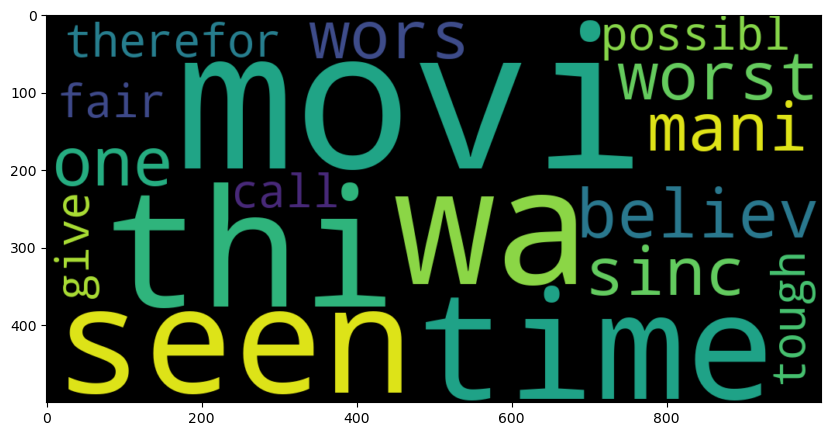

In [58]:
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

### Word cloud untuk review negatif

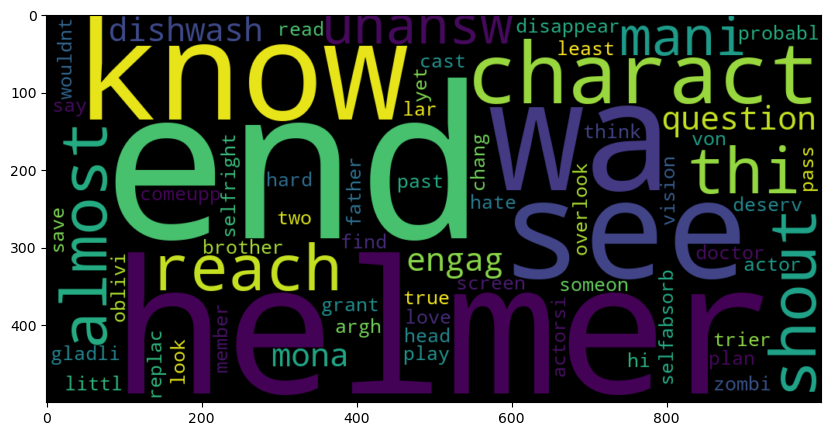

In [59]:
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()